#SVM Classifier with BOW Embeddings

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import torch
#allocates 80% of data for training and 20% for validation
df_train, df_val = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
encoded_training_inputs= tokenizer(list(df_train['text']), padding=True, truncation=True, return_tensors='pt')
encoded_validation_inputs = tokenizer(list(df_val['text']), padding=True, truncation=True, return_tensors='pt')
# Get embeddings on training data
with torch.no_grad():
    output = bert_model(**encoded_training_inputs)

last_hidden_state = output.last_hidden_state
X_train_embeddings = last_hidden_state.mean(dim=1).squeeze().numpy()

# Get embeddings on validation data
with torch.no_grad():
    output = bert_model(**encoded_validation_inputs)

last_hidden_state = output.last_hidden_state
X_val_embeddings = last_hidden_state.mean(dim=1).squeeze().numpy()
#Assigns 0 to negative, 1 to neutral, and 2 to positive
df_train['target'] = df_train.airline_sentiment.apply(sentiment_to_numeric)
df_val['target'] = df_val.airline_sentiment.apply(sentiment_to_numeric)

In [ ]:
RANDOM_SEED = 11

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import time
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import torch
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, accuracy_score, average_precision_score, precision_score
import seaborn as sns

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

In [ ]:
df = pd.read_csv('AirlineTweets.csv')[['tweet_id', 'airline_sentiment', 'text']]



In [ ]:
cleanedData = []

lemma = WordNetLemmatizer()
swords = stopwords.words("english")
for text in df["text"]:

    # Cleaning links
    text = re.sub(r'http\S+', '', text)

    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",text)

    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]

    # Removing stopwords
    text = [word for word in text if word not in swords]

    # Joining
    text = " ".join(text)

    cleanedData.append(text)

In [ ]:

sentiment_to_numeric = lambda sentiment: {'negative': 0, 'neutral': 1, 'positive': 2}.get(sentiment.lower(), -1)
df["airline_sentiment"].value_counts()
df['target'] = df.airline_sentiment.apply(sentiment_to_numeric)

In [ ]:
vectorizer = CountVectorizer(max_features=10000)
BOW = vectorizer.fit_transform(cleanedData)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(BOW,np.asarray(df["target"]))

In [ ]:
from sklearn.svm import SVC
start_time = time.time()

model = SVC()
model.fit(x_train,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting SVC took {} seconds".format(process_time))

Fitting SVC took 20.31 seconds


In [ ]:
class_names = ['negative', 'neutral', 'positive']

predictions = model.predict(x_test)
print(classification_report(y_test, predictions, target_names=class_names))


              precision    recall  f1-score   support

    negative       0.79      0.93      0.85      2284
     neutral       0.66      0.44      0.53       805
    positive       0.75      0.57      0.65       571

    accuracy                           0.77      3660
   macro avg       0.74      0.65      0.68      3660
weighted avg       0.76      0.77      0.75      3660



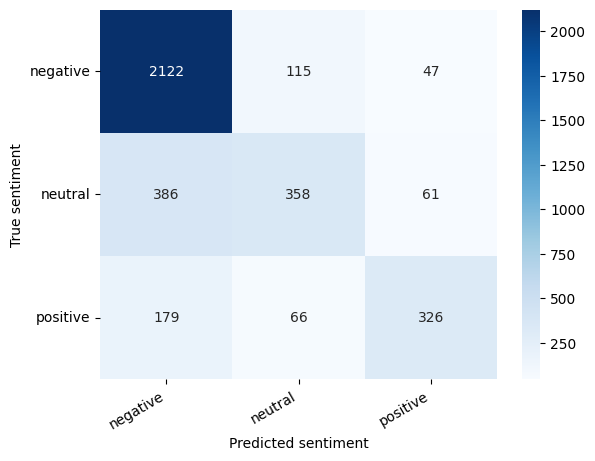

In [ ]:
cm = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
result_df = pd.DataFrame({'Prediction': predictions, 'Actual': y_test})
result_df.to_csv('svm_predictions.csv')

In [ ]:
positiveFD = nltk.FreqDist(word for text in df[df["airline_sentiment"] == 2]["text"] for word in text.lower().split())
negativeFD = nltk.FreqDist(word  for text in df[df["airline_sentiment"] == 0]["text"] for word in text.lower().split())
neutralDF = nltk.FreqDist(word  for text in df[df["airline_sentiment"] == 1]["text"] for word in text.lower().split())

In [ ]:
positiveFD

FreqDist({})

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize
from collections import Counter


# Function to clean text
def clean_text(text):
    # Remove non-alphanumeric characters and symbols
    cleaned_text = re.sub(r'[^A-Za-z\s]', '', text)
    return cleaned_text

# Clean the text in the DataFrame
df['text'] = df['text'].apply(clean_text)

# Tokenize the tweets
df['tokens'] = df['text'].apply(word_tokenize)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])


# Separate tweets into positive, negative, and neutral categories
positive_tweets = df[df['target'] == 2]
negative_tweets = df[df['target'] == 1]
neutral_tweets = df[df['target'] == 0]

# Count the frequency of words in each category
positive_word_counts = Counter([word for tokens in positive_tweets['tokens'] for word in tokens])
negative_word_counts = Counter([word for tokens in negative_tweets['tokens'] for word in tokens])
neutral_word_counts = Counter([word for tokens in neutral_tweets['tokens'] for word in tokens])

# Get the most frequent words in each category
most_common_positive = positive_word_counts.most_common(50)
most_common_negative = negative_word_counts.most_common(50)
most_common_neutral = neutral_word_counts.most_common(50)

# Get the most frequent words in each category as lists
most_common_positive = [word for word, freq in positive_word_counts.most_common(50)]
most_common_negative = [word for word, freq in negative_word_counts.most_common(50)]
most_common_neutral = [word for word, freq in neutral_word_counts.most_common(50)]

print("Most frequent words in positive tweets:", most_common_positive)
print("Most frequent words in negative tweets:", most_common_negative)
print("Most frequent words in neutral tweets:", most_common_neutral)

Most frequent words in positive tweets: ['JetBlue', 'SouthwestAir', 'united', 'AmericanAir', 'flight', 'thanks', 'Thanks', 'USAirways', 'Thank', 'thank', 'great', 'service', 'VirginAmerica', 'get', 'customer', 'guys', 'much', 'love', 'time', 'good', 'got', 'today', 'best', 'help', 'amp', 'awesome', 'airline', 'us', 'Im', 'back', 'crew', 'amazing', 'flying', 'fly', 'flights', 'like', 'would', 'made', 'home', 'response', 'Great', 'know', 'gate', 'day', 'plane', 'see', 'work', 'Flight', 'appreciate', 'new']
Most frequent words in negative tweets: ['JetBlue', 'united', 'SouthwestAir', 'flight', 'AmericanAir', 'USAirways', 'get', 'VirginAmerica', 'flights', 'help', 'need', 'please', 'Im', 'would', 'Thanks', 'Flight', 'DM', 'fleek', 'know', 'tomorrow', 'fleets', 'Cancelled', 'way', 'time', 'amp', 'change', 'back', 'one', 'like', 'number', 'fly', 'today', 'us', 'go', 'flying', 'see', 'email', 'got', 'check', 'make', 'ticket', 'travel', 'follow', 'United', 'AA', 'RT', 'dont', 'sent', 'weather'